In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime as dt_1

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Define inspector variable to get column names
inspector = inspect(engine)

In [11]:
# Column names for table, Measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Column names for table, Station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

date_frmt = '%Y-%m-%d'
last_date = dt_1.strptime(str(session.query(func.max(Measurement.date)).first()[0]), date_frmt)
# I used 366 days because the example uses that exact information.  Not sure which is better for grading...
delta_days = 366

earliest_date = last_date - dt.timedelta(days=delta_days)

# Perform a query to retrieve the data and precipitation scores

query_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= earliest_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

query_df = pd.DataFrame(query_results)
query_df = (query_df.set_index('date')).sort_index()
query_df = query_df.rename(columns={'prcp': 'precipitation'})

query_df.head(10)

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


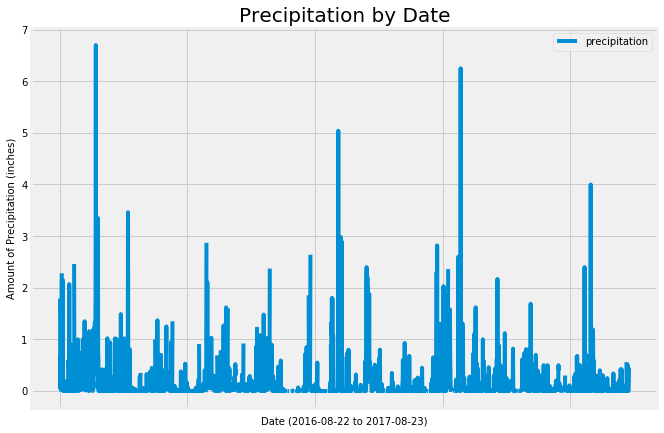

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
query_df.plot(kind='line', figsize=(10,7))
plt.title('Precipitation by Date', fontsize=20)
plt.xlabel(f'Date ({dt_1.strftime(earliest_date, date_frmt)} to {dt_1.strftime(last_date, date_frmt)})', fontsize=10)
plt.ylabel('Amount of Precipitation (inches)', fontsize=10);

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activity_query = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by((func.count(Measurement.station)).desc()).all()

activity_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = activity_query[0][0]
temp = Measurement.tobs
sel = [func.min(temp), func.max(temp), func.avg(temp)]

session.query(*sel).filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
temp_results = session.query(Measurement.tobs).\
    filter((Measurement.date >= earliest_date)&(Measurement.station == most_active)).all()

temp_active_df = pd.DataFrame(temp_results)
temp_active_df = temp_active_df.rename(columns={'tobs': 'temperature'})

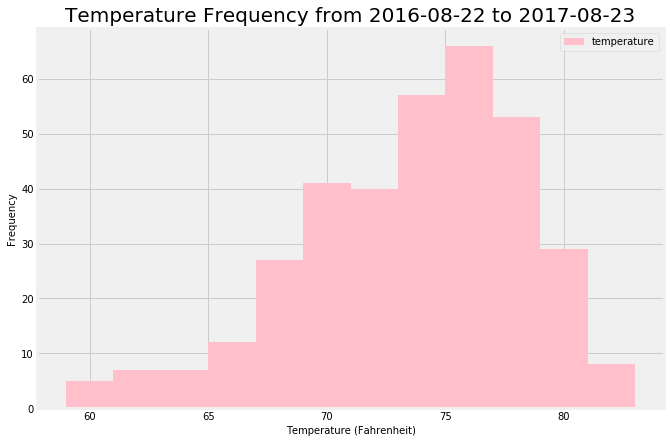

In [20]:
# Plot the results as a histogram
temp_active_df.plot(kind='hist', bins=12, color='pink', figsize=(10,7))
plt.title(f'Temperature Frequency from {dt_1.strftime(earliest_date, date_frmt)} to \
{dt_1.strftime(last_date, date_frmt)}', fontsize=20)
plt.xlabel('Temperature (Fahrenheit)', fontsize=10)
plt.ylabel('Frequency', fontsize=10);

# Temperature Analysis

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    temp_info = (session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all())[0]


    
    print(f"""Min Temp (F): {temp_info[0]}
Avg Temp (F): {round(temp_info[1],1)}
Max Temp (F): {temp_info[2]}""")
    
    return temp_info

# function usage example
calc_temps('2012-02-28', '2012-03-05')

Min Temp (F): 62.0
Avg Temp (F): 69.6
Max Temp (F): 74.0


(62.0, 69.57142857142857, 74.0)

In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2019-05-12'
end_date = '2019-05-27'

calc_start_date = '2017-05-12'
calc_end_date = '2017-05-27'

trip_temp = calc_temps(calc_start_date, calc_end_date)

trip_temp

Min Temp (F): 68.0
Avg Temp (F): 74.8
Max Temp (F): 87.0


(68.0, 74.84444444444445, 87.0)

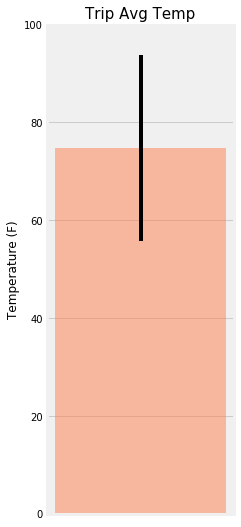

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,9))

plt.bar(x='', height=trip_temp[1], color='coral', alpha=0.5, yerr=(trip_temp[2]-trip_temp[0]))

plt.title('Trip Avg Temp', fontsize=15)
plt.xticks([1])
plt.yticks(np.arange(0,120,20))
plt.ylabel('Temperature (F)');

# Daily Rainfall Average

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates
# using the previous year's matching dates.

# Sort this in descending order by precipitation amount
# and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation,
       func.sum(Measurement.prcp)
      ]

station_prcp_results = session.query(*sel).group_by(Measurement.station).\
    filter((Measurement.date >= calc_start_date)&(Measurement.date <= calc_end_date)&\
           (Measurement.station == Station.station)).order_by((func.sum(Measurement.prcp)).desc()).all()

print(f"""Precipitation Totals by Station for {start_date} through {end_date}
--------------------------""")

for result in station_prcp_results:
    print(f"""Station: {result[0]}
Name: {result[1]}
Latitude: {result[2]}
Longitude: {result[3]}
Elevation: {result[4]}
Precip Total: {result[5]}
--------------------------""")


Precipitation Totals by Station for 2019-05-12 through 2019-05-27
--------------------------
Station: USC00516128
Name: MANOA LYON ARBO 785.2, HI US
Latitude: 21.3331
Longitude: -157.8025
Elevation: 152.4
Precip Total: 6.449999999999999
--------------------------
Station: USC00519523
Name: WAIMANALO EXPERIMENTAL FARM, HI US
Latitude: 21.33556
Longitude: -157.71139
Elevation: 19.5
Precip Total: 1.68
--------------------------
Station: USC00513117
Name: KANEOHE 838.1, HI US
Latitude: 21.4234
Longitude: -157.8015
Elevation: 14.6
Precip Total: 1.3399999999999999
--------------------------
Station: USC00519281
Name: WAIHEE 837.5, HI US
Latitude: 21.45167
Longitude: -157.84888999999998
Elevation: 32.9
Precip Total: 1.29
--------------------------
Station: USC00514830
Name: KUALOA RANCH HEADQUARTERS 886.9, HI US
Latitude: 21.5213
Longitude: -157.8374
Elevation: 7.0
Precip Total: 0.51
--------------------------
Station: USC00519397
Name: WAIKIKI 717.2, HI US
Latitude: 21.2716
Longitude: -157.8

## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date, will_print='n'):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        will_print (str): 'y' or 'n'.  'y' will tell the function to print out something pretty. 
            'n' is default and will not print pretty.
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    daily_info = (session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all())[0]

    if will_print == 'y':
        print(f"""Min Temp (F): {daily_info[0]}
Avg Temp (F): {round(daily_info[1],1)}
Max Temp (F): {daily_info[2]}""")
    
    return daily_info
    
daily_normals("01-01", 'y')

Min Temp (F): 62.0
Avg Temp (F): 69.2
Max Temp (F): 77.0


(62.0, 69.15384615384616, 77.0)

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

dt_start_date = dt_1.strptime(start_date, date_frmt)
dt_end_date = dt_1.strptime(end_date, date_frmt)

day = dt_start_date
normals = []
days = []

while day <= dt_end_date:
    daily_result = daily_normals(dt_1.strftime(day, '%m-%d'))
    normals.append(daily_result)
    days.append(day)
    day += dt.timedelta(days=1)
    
normals

[(65.0, 73.13793103448276, 79.0),
 (67.0, 73.14285714285714, 79.0),
 (63.0, 73.89285714285714, 80.0),
 (63.0, 73.69090909090909, 79.0),
 (68.0, 74.37931034482759, 80.0),
 (68.0, 74.45, 79.0),
 (68.0, 74.10714285714286, 82.0),
 (65.0, 73.80701754385964, 79.0),
 (68.0, 73.89655172413794, 79.0),
 (64.0, 72.96428571428571, 80.0),
 (64.0, 74.45614035087719, 80.0),
 (68.0, 74.94827586206897, 87.0),
 (67.0, 73.94827586206897, 79.0),
 (68.0, 74.27586206896552, 79.0),
 (65.0, 74.03636363636363, 82.0),
 (65.0, 74.49090909090908, 80.0)]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(data=normals,columns=['tmin', 'tavg', 'tmax'])
normals_df['date'] = days
normals_df = normals_df.set_index('date')
normals_df

,tmin,tavg,tmax
date,,,
2019-05-12,65.0,73.137931,79.0
2019-05-13,67.0,73.142857,79.0
2019-05-14,63.0,73.892857,80.0
2019-05-15,63.0,73.690909,79.0
2019-05-16,68.0,74.379310,80.0
2019-05-17,68.0,74.450000,79.0
2019-05-18,68.0,74.107143,82.0
2019-05-19,65.0,73.807018,79.0
2019-05-20,68.0,73.896552,79.0


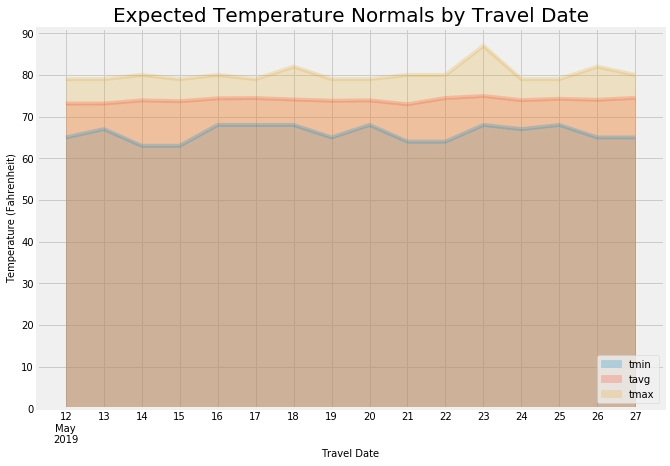

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, xticks=days, yticks=(np.arange(0,100,10)), alpha=.25, figsize=(10,7))
plt.grid(True)
plt.title('Expected Temperature Normals by Travel Date', fontsize=20)
plt.xlabel('Travel Date', fontsize=10)
plt.ylabel('Temperature (Fahrenheit)', fontsize=10)
plt.legend(loc='lower right');